# Задача 4 Определение подходящей температуры плавки

In [519]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from numba import njit, jit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import xgboost as xgb


In [400]:
!python -m pip install xgboost


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [401]:
from random import randint

In [402]:
sns.set()
RANDOM_SEED = 42

In [403]:
# Для того, чтобы находить и удалять лишние объекты из памяти
import sys
ipython_vars = ["In", "Out", "exit", "quit", "get_ipython", "ipython_vars"]
mem = {
    key: value
    for key, value in sorted(
        [
            (x, sys.getsizeof(globals().get(x)))
            for x in dir()
            if not x.startswith("_") and x not in sys.modules and x not in ipython_vars
        ],
        key=lambda x: x[1],
        reverse=True,
    )
}

## Исходные данные

### Импорт и анализ данных

In [404]:
from pathlib import Path

src_folder = Path("final_steel")
electrod_data_path = src_folder / "data_arc.csv"
addons_data_path = src_folder / "data_bulk.csv"
addons_time_data_path = src_folder / "data_bulk_time.csv"
gas_data_path = src_folder / "data_gas.csv"
temp_data_path = src_folder / "data_temp.csv"
wire_addons_data_path = src_folder / "data_wire.csv"
wire_addons_time_data_path = src_folder / "data_wire_time.csv"


In [405]:
electrod_df = pd.read_csv(electrod_data_path)

In [406]:
addons_df = pd.read_csv(addons_data_path)

In [407]:
addons_time_df = pd.read_csv(addons_time_data_path)

In [408]:
gas_df = pd.read_csv(gas_data_path)

In [409]:
temp_df = pd.read_csv(temp_data_path)

In [410]:
wire_addons_df = pd.read_csv(wire_addons_data_path)

In [411]:
wire_addons_time_df = pd.read_csv(wire_addons_time_data_path)

Сравним длину таблиц

In [412]:
print(f"{len(electrod_df)=}")
print(f"{len(addons_df)=}")
print(f"{len(addons_time_df)=}")
print(f"{len(gas_df)=}")
print(f"{len(temp_df)=}")
print(f"{len(wire_addons_df)=}")
print(f"{len(wire_addons_time_df)=}")

len(electrod_df)=14876
len(addons_df)=3129
len(addons_time_df)=3129
len(gas_df)=3239
len(temp_df)=15907
len(wire_addons_df)=3081
len(wire_addons_time_df)=3081


### Преобразование данных

Таблицы разной длины. Посмотрим на их свойства и преобразуем типы

In [413]:
electrod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [414]:
electrod_df.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [415]:
electrod_df.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [416]:
electrod_df = electrod_df.astype({
    "key": np.int16, 
    "Начало нагрева дугой": "datetime64[ns]",
    "Конец нагрева дугой": "datetime64[ns]",
    "Активная мощность": np.float16,
    "Реактивная мощность": np.float16})

In [417]:
electrod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int16         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float16       
 4   Реактивная мощность   14876 non-null  float16       
dtypes: datetime64[ns](2), float16(2), int16(1)
memory usage: 319.7 KB


In [418]:
addons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [419]:
addons_df.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [420]:
addons_df = addons_df.astype(np.float16)
addons_df = addons_df.astype({"key": np.int16})
addons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int16  
 1   Bulk 1   252 non-null    float16
 2   Bulk 2   22 non-null     float16
 3   Bulk 3   1298 non-null   float16
 4   Bulk 4   1014 non-null   float16
 5   Bulk 5   77 non-null     float16
 6   Bulk 6   576 non-null    float16
 7   Bulk 7   25 non-null     float16
 8   Bulk 8   1 non-null      float16
 9   Bulk 9   19 non-null     float16
 10  Bulk 10  176 non-null    float16
 11  Bulk 11  177 non-null    float16
 12  Bulk 12  2450 non-null   float16
 13  Bulk 13  18 non-null     float16
 14  Bulk 14  2806 non-null   float16
 15  Bulk 15  2248 non-null   float16
dtypes: float16(15), int16(1)
memory usage: 97.9 KB


In [421]:
addons_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [422]:
keys = addons_time_df.key
addons_time_df = pd.concat([
    addons_time_df.loc[:, addons_time_df.columns != "key"]
                  .astype("datetime64[ns]"),
    keys], axis=1)
addons_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Bulk 1   252 non-null    datetime64[ns]
 1   Bulk 2   22 non-null     datetime64[ns]
 2   Bulk 3   1298 non-null   datetime64[ns]
 3   Bulk 4   1014 non-null   datetime64[ns]
 4   Bulk 5   77 non-null     datetime64[ns]
 5   Bulk 6   576 non-null    datetime64[ns]
 6   Bulk 7   25 non-null     datetime64[ns]
 7   Bulk 8   1 non-null      datetime64[ns]
 8   Bulk 9   19 non-null     datetime64[ns]
 9   Bulk 10  176 non-null    datetime64[ns]
 10  Bulk 11  177 non-null    datetime64[ns]
 11  Bulk 12  2450 non-null   datetime64[ns]
 12  Bulk 13  18 non-null     datetime64[ns]
 13  Bulk 14  2806 non-null   datetime64[ns]
 14  Bulk 15  2248 non-null   datetime64[ns]
 15  key      3129 non-null   int64         
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [423]:
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [424]:
gas_df.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [425]:
gas_df = gas_df.astype({
    "key": np.int16,
    "Газ 1": np.float16})
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int16  
 1   Газ 1   3239 non-null   float16
dtypes: float16(1), int16(1)
memory usage: 12.8 KB


In [426]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [427]:
temp_df.describe()


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [428]:
temp_df = temp_df.astype({
    "key": np.int16,
    "Время замера": "datetime64[ns]",
    "Температура": np.float16})
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int16         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float16       
dtypes: datetime64[ns](1), float16(1), int16(1)
memory usage: 186.5 KB


In [429]:
wire_addons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [430]:
wire_addons_df.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [431]:
wire_addons_df = wire_addons_df.astype(np.float16)
wire_addons_df = wire_addons_df.astype({"key": np.int16})
wire_addons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int16  
 1   Wire 1  3055 non-null   float16
 2   Wire 2  1079 non-null   float16
 3   Wire 3  63 non-null     float16
 4   Wire 4  14 non-null     float16
 5   Wire 5  1 non-null      float16
 6   Wire 6  73 non-null     float16
 7   Wire 7  11 non-null     float16
 8   Wire 8  19 non-null     float16
 9   Wire 9  29 non-null     float16
dtypes: float16(9), int16(1)
memory usage: 60.3 KB


In [432]:
wire_addons_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [433]:
keys = wire_addons_time_df.key
wire_addons_time_df = pd.concat([
    wire_addons_time_df.loc[:, wire_addons_time_df.columns != "key"]
                  .astype("datetime64[ns]"),
    keys], axis=1)
wire_addons_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Wire 1  3055 non-null   datetime64[ns]
 1   Wire 2  1079 non-null   datetime64[ns]
 2   Wire 3  63 non-null     datetime64[ns]
 3   Wire 4  14 non-null     datetime64[ns]
 4   Wire 5  1 non-null      datetime64[ns]
 5   Wire 6  73 non-null     datetime64[ns]
 6   Wire 7  11 non-null     datetime64[ns]
 7   Wire 8  19 non-null     datetime64[ns]
 8   Wire 9  29 non-null     datetime64[ns]
 9   key     3081 non-null   int64         
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


### Первичный анализ данных

Посмотрим на графики и удалим элементы, которые сильно выбиваются из общей картины.

In [434]:
to_delete = set()

<Axes: >

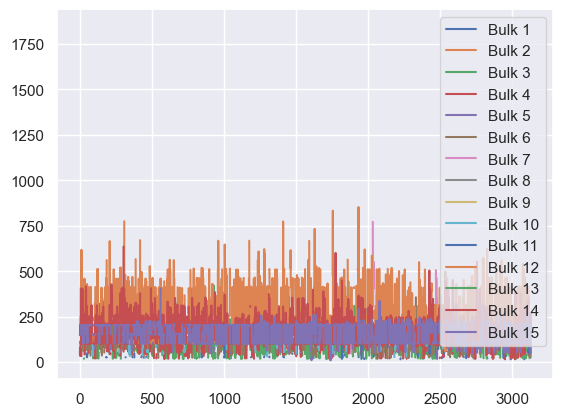

In [435]:
addons_df.loc[:, addons_df.columns != "key"].plot()

Анализ наличия данных в различных колонках addons_df показал, что эта таблицы несет в себе информацию о том, в какие партии какие материалы добавлялись. При этом... 

<Axes: >

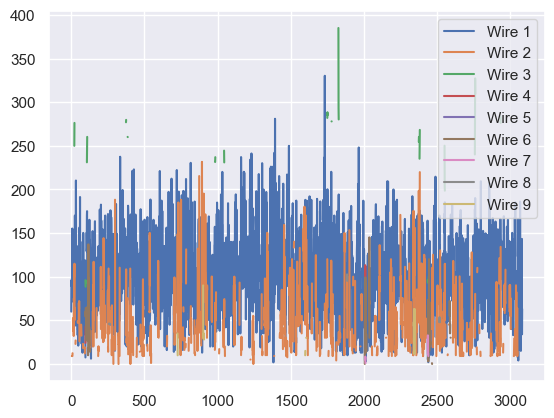

In [436]:
wire_addons_df.loc[:, wire_addons_df.columns != "key"].plot()

Анализ наличия данных в различных колонках wire_addons_df показал, что эта таблицы несет в себе информацию о том, в какие партии какие материалы добавлялись

<Axes: >

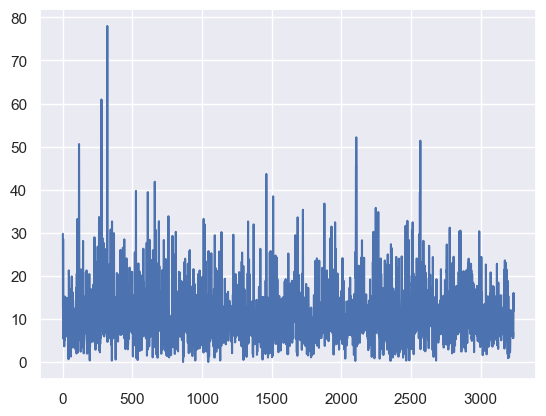

In [437]:
gas_df["Газ 1"].plot()

In [438]:
to_delete.update(gas_df[gas_df["Газ 1"] > 45]["key"].values)

<Axes: >

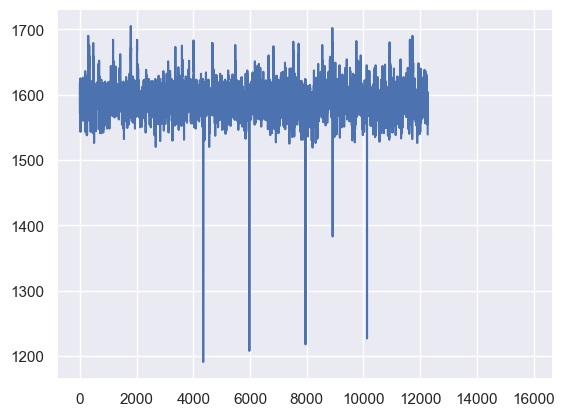

In [439]:
temp_df["Температура"].plot()

In [440]:
to_delete.update(temp_df[temp_df["Температура"] < 1500]["key"].values)

<Axes: >

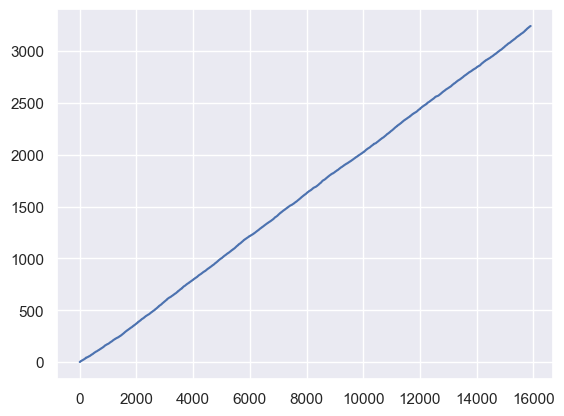

In [441]:
temp_df.key.plot()

## Агрегирование данных

### Группируем данные по партиям (key)

In [442]:

temper_dict = dict(tuple(temp_df.groupby("key")))

In [443]:
electrod_dict = dict(tuple(electrod_df.groupby("key")))

In [444]:
gas_dict = dict(tuple(gas_df.groupby("key")))

In [445]:
addons_dict = dict(tuple(addons_df.groupby("key")))

In [446]:
addons_time_dict = dict(tuple(addons_time_df.groupby("key")))

In [447]:
wire_addons_dict = dict(tuple(wire_addons_df.groupby("key")))

In [448]:
wire_addons_time_dict = dict(tuple(wire_addons_time_df.groupby("key")))

In [449]:
for i in (temper_dict,
          electrod_dict,
          gas_dict,
          addons_dict,
          addons_time_dict,
          wire_addons_dict,
          wire_addons_time_dict):
    print(len(i))

3216
3214
3239
2564
3129
2525
3081


In [450]:
del addons_time_df
del electrod_df
del wire_addons_time_df
del temp_df
del addons_df
del wire_addons_df
del keys
del gas_df    

Исследуем причину малого количества партий в addons_dict, wire_addons_dict

<Axes: >

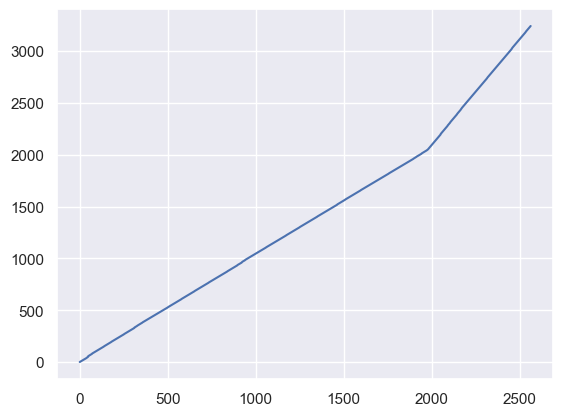

In [451]:
addons_keys = pd.Series(addons_dict.keys())
addons_keys.plot()

<Axes: >

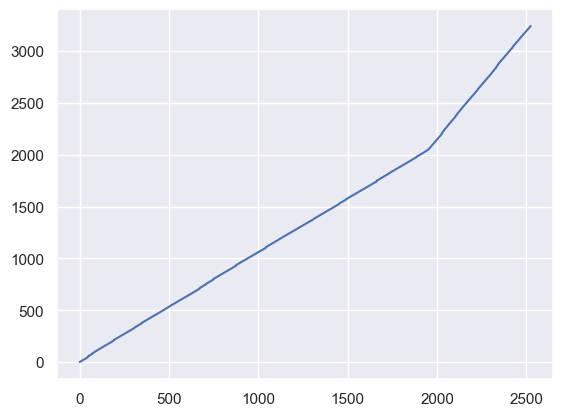

In [452]:
wire_addons_keys = pd.Series(wire_addons_dict.keys())
wire_addons_keys.plot()

<Axes: >

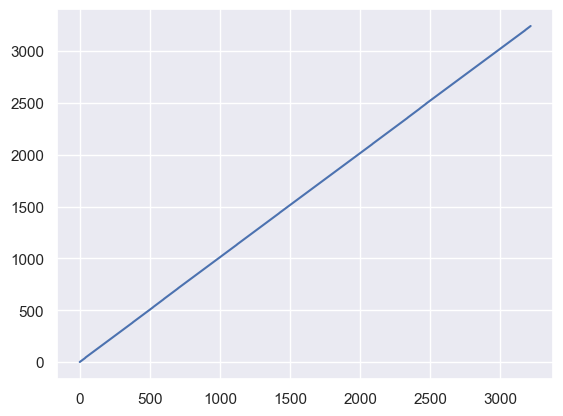

In [453]:
temper_keys = pd.Series(temper_dict.keys())
temper_keys.plot()

In [454]:
addons_dict

{1:    key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
 0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
 
    Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
 0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  ,
 2:    key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
 1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
 
    Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
 1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  ,
 3:    key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
 2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
 
    Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
 2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  ,
 4:    key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
 3    4     NaN     NaN     NaN    81.0     NaN     

In [455]:
addons_time_dict

{1:   Bulk 1 Bulk 2 Bulk 3              Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
 0    NaT    NaT    NaT 2019-05-03 11:21:30    NaT    NaT    NaT    NaT    NaT   
 
   Bulk 10 Bulk 11             Bulk 12 Bulk 13             Bulk 14  \
 0     NaT     NaT 2019-05-03 11:03:52     NaT 2019-05-03 11:03:52   
 
               Bulk 15  key  
 0 2019-05-03 11:03:52    1  ,
 2:   Bulk 1 Bulk 2 Bulk 3              Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
 1    NaT    NaT    NaT 2019-05-03 11:46:38    NaT    NaT    NaT    NaT    NaT   
 
   Bulk 10 Bulk 11             Bulk 12 Bulk 13             Bulk 14  \
 1     NaT     NaT 2019-05-03 11:40:20     NaT 2019-05-03 11:40:20   
 
               Bulk 15  key  
 1 2019-05-03 11:40:20    2  ,
 3:   Bulk 1 Bulk 2 Bulk 3              Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
 2    NaT    NaT    NaT 2019-05-03 12:31:06    NaT    NaT    NaT    NaT    NaT   
 
   Bulk 10 Bulk 11             Bulk 12 Bulk 13             Bulk 14  \
 2     NaT     Na

Попробуем выявить марки стали по композициям добавок Bulk

In [456]:
key_steelSort = {}
for key, df in addons_dict.items():
    df: pd.DataFrame
    key_steelSort[key] = df.dropna(axis=1, how='all').columns.values.tolist()

In [457]:
sorts = tuple(set([tuple(i) for i in key_steelSort.values()]))

In [458]:
len(sorts)

148

Получилось 148 сортов. Проверим на сколько визуально отличаются одинаковые сорта по количественному составу

In [459]:
# генератор составов по сортам
def get_compositions(sort_: tuple[str]):
    for df in addons_dict.values():
        if tuple(df.dropna(axis=1, how='all').columns.values.tolist()) == sort_:
            yield df

In [460]:
gen = (i for i in get_compositions(sorts[0]))

In [461]:
next(gen)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2771,2876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.0,NaN,202.0,NaN
2772,2876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,106.0,NaN
2773,2876,NaN,NaN,208.0,NaN,74.0,252.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.0,NaN


In [462]:
next(gen)

StopIteration: 

Видно, что наименования совппадают, но концентрация различается. Проверим для этих партий температуру

In [464]:
print(temper_dict[909], temper_dict[1028], temper_dict[1068])

      key        Время замера  Температура
4565  909 2019-06-05 20:36:43       1540.0
4566  909 2019-06-05 20:44:28       1549.0
4567  909 2019-06-05 20:52:39       1569.0
4568  909 2019-06-05 20:55:41       1576.0        key        Время замера  Температура
5114  1028 2019-06-10 01:48:14       1575.0
5115  1028 2019-06-10 01:48:47       1574.0
5116  1028 2019-06-10 02:04:53       1561.0
5117  1028 2019-06-10 02:15:43       1581.0
5118  1028 2019-06-10 02:18:47       1582.0
5119  1028 2019-06-10 02:21:09       1593.0
5120  1028 2019-06-10 02:22:04       1585.0        key        Время замера  Температура
5316  1068 2019-06-11 13:33:46       1552.0
5317  1068 2019-06-11 13:41:01       1563.0
5318  1068 2019-06-11 13:48:29       1583.0
5319  1068 2019-06-11 13:52:28       1589.0


Для сравнения возьмем некоторые другие партии

In [465]:
print(temper_dict[randint(1, 3000)], temper_dict[randint(1, 3000)], temper_dict[randint(1, 3000)])

        key        Время замера  Температура
12512  2549 2019-08-07 20:39:20       1582.0
12513  2549 2019-08-07 20:46:56          NaN
12514  2549 2019-08-07 20:52:01          NaN
12515  2549 2019-08-07 20:54:26          NaN        key        Время замера  Температура
8369  1699 2019-07-02 22:03:04       1563.0
8370  1699 2019-07-02 22:10:44       1582.0
8371  1699 2019-07-02 22:14:44       1587.0
8372  1699 2019-07-02 22:20:00       1590.0
8373  1699 2019-07-02 22:20:38       1589.0       key        Время замера  Температура
3670  730 2019-05-30 08:34:24       1545.0
3671  730 2019-05-30 08:43:57       1558.0
3672  730 2019-05-30 08:50:46       1573.0
3673  730 2019-05-30 08:56:03       1585.0


In [466]:
addons_dict[1213]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1165,1213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.0,NaN,108.0,102.0


Гипотезу сортов стали отбрасываем.

## Представление партии в виде матрицы последовательности операция

In [467]:
batch = randint(1, 3000)

In [468]:
electrod_dict[batch]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
328,70,2019-05-05 21:21:17,2019-05-05 21:23:25,0.417236,0.376465
329,70,2019-05-05 21:24:46,2019-05-05 21:28:28,0.823730,0.694824
330,70,2019-05-05 21:34:43,2019-05-05 21:35:55,0.261475,0.207764
331,70,2019-05-05 21:37:22,2019-05-05 21:38:57,0.347168,0.272705
332,70,2019-05-05 21:41:01,2019-05-05 21:42:07,0.250244,0.197021


In [469]:
addons_time_dict[batch]

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,key
61,NaT,NaT,NaT,2019-05-05 21:30:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-05 21:27:49,NaT,2019-05-05 21:27:49,2019-05-05 21:27:49,70


In [470]:
wire_addons_time_dict[batch]

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,key
61,2019-05-05 21:29:33,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,70


In [471]:
wire_addons_dict[batch]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
61,70,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [472]:
temper_dict[batch]

,key,Время замера,Температура
405,70,2019-05-05 21:24:05,1583.0
406,70,2019-05-05 21:31:13,1606.0
407,70,2019-05-05 21:31:48,1596.0
408,70,2019-05-05 21:34:19,1583.0
409,70,2019-05-05 21:37:01,1584.0
410,70,2019-05-05 21:40:22,1586.0
411,70,2019-05-05 21:42:24,1586.0


In [473]:
addons_dict[969]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
926,969,NaN,NaN,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.0,NaN


In [474]:
wire_addons_dict[batch]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
61,70,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [475]:
gas_dict[batch]

,key,Газ 1
69,70,6.6875


Из анализа данных о времени добавления аддонов и проволоки выяснилось, что они либо не корректны, либо неполные. Пока отбосим их.
Можно выдвинуть гипотезу о том, что для определения конечной температуры не важен порядок добавления присадок, а лишь их общее количество, т.е. конечный хим состав. Тогда важным остается 
* посчитать хим состав по присадкам
* проверить общую поданную мощность, деленную на массу присадок
* количество пропущенного газа
* температур перед сливом

Матрица плавки будет состоять из следующих компонентов. Важно на вход модели подавать матрицу одной размерности.
* Пусть по оси Х будут категории (int в типе float64) шагов - bulk, wire. Порядок выполнения этих шагов не важен. 15 + 9 = 24 колонки
* Далее будет располагаться время выполнения шага.
* Ниже колличество подаваемого материала
* Если в этот шаг (между текущим и следующим шагом) электроды были включены, то ставим значение подаваемой Активной мощности. Иначе 0
* Если в этот шаг (между текущим и следующим шагом) подавался газ продувки, то флаг 1.  Иначе 0



Напишем такую функцию

In [476]:
def data_packet_to_array(
    electrod_info: pd.DataFrame,
    addons_info: pd.DataFrame,
    wire_addons_info: pd.DataFrame,
    gas_info: pd.DataFrame,
    temper_info: pd.DataFrame) -> np.array:
    
    ar = np.zeros((27), np.float16)
    
    ads = addons_info.drop(["key"], axis=1).sum(axis=0, numeric_only=True)
    wrs = wire_addons_info.drop(["key"], axis=1).sum(axis=0)
    
    ar[0:len(ads)] = ads
    ar[len(ads)-1:len(ads) + len(wrs) - 1] = wrs
    
    ar[len(ads) + len(wrs)- 2: len(ads) + len(wrs) + 3] = np.array(
    [temper_info["Температура"].values[0],
     electrod_info["Активная мощность"].values[0],
     electrod_info["Активная мощность"].values[-1],
     gas_info["Газ 1"].values[0],
     temper_info["Температура"].values[-1]
    ])
    if np.isnan(np.sum(ar)):
        raise KeyError("Incorrect final temp")
    return ar

Преобразуем данные в соответствующий формат.
Первое преобразование показало, что в 735 партиях не применялись добавки, либо они не были записаны. Попробуем заполнить отсутствующие данные нулями.

In [477]:
input_data = list()
not_converted = list()
addons_empty_df = pd.DataFrame(data=[np.zeros(16)], columns=list(addons_dict[49]))
wire_addons_empty_df = pd.DataFrame(data=[np.zeros(10)], columns=list(wire_addons_dict[49]))
for key in range(len(temper_dict)):
    if key in to_delete:
        continue
    try:
        input_data.append(data_packet_to_array(
            electrod_dict[key],
            addons_dict.get(key, addons_empty_df),
            wire_addons_dict.get(key, wire_addons_empty_df),
            gas_dict[key],
            temper_dict[key]
        )
                         )
    except KeyError as e:
        print(e, key)
        not_converted.append(key)

0 0
41 41
42 42
193 193
195 195
259 259
279 279
355 355
382 382
506 506
529 529
540 540
607 607
683 683
710 710
766 766
1133 1133
1300 1300
1437 1437
2031 2031
2103 2103
2278 2278
2356 2356
2373 2373
2446 2446
2469 2469
2491 2491
'Incorrect final temp' 2500
'Incorrect final temp' 2501
'Incorrect final temp' 2502
'Incorrect final temp' 2503
'Incorrect final temp' 2504
'Incorrect final temp' 2505
'Incorrect final temp' 2506
'Incorrect final temp' 2507
'Incorrect final temp' 2508
'Incorrect final temp' 2509
'Incorrect final temp' 2510
'Incorrect final temp' 2511
'Incorrect final temp' 2512
'Incorrect final temp' 2513
'Incorrect final temp' 2514
'Incorrect final temp' 2515
'Incorrect final temp' 2516
'Incorrect final temp' 2517
'Incorrect final temp' 2518
'Incorrect final temp' 2519
'Incorrect final temp' 2520
'Incorrect final temp' 2521
'Incorrect final temp' 2522
'Incorrect final temp' 2523
'Incorrect final temp' 2524
'Incorrect final temp' 2525
'Incorrect final temp' 2526
'Incorrect fin

In [478]:
len(not_converted)

741

In [479]:
temper_dict[2966]

,key,Время замера,Температура
14629,2966,2019-08-23 03:05:13,1614.0
14630,2966,2019-08-23 03:11:39,NaN
14631,2966,2019-08-23 03:19:52,NaN
14632,2966,2019-08-23 03:33:38,NaN
14633,2966,2019-08-23 03:37:58,NaN


In [480]:
len(list(filter(lambda key:  temper_dict[key]["Температура"].isna().sum(), temper_dict)))

739

In [481]:
correct_input = pd.DataFrame(input_data)

Получили компактное представление для подачи в модель. При этом не малая часть данных была отброшена, т.к. отсутствовали данные о температуре слива.

In [482]:
del electrod_dict
del temper_dict
del gas_dict
del addons_dict
del wire_addons_dict

## Выбор и обучение модели

In [483]:
X = correct_input.drop(26, axis=1)
y = correct_input[27]

In [523]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_SEED)
scaler = StandardScaler()
scaler.fit(X_train)
    
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [524]:
param_grid = {
    'max_depth': [5, 6, 9],
    'n_estimators': [500, 550, 600, 700]
}


xgb_model = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator = xgb_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 4)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': [5, 6, 9],
                         'n_estimators': [500, 550, 600, 700]},
             verbose=4)

In [525]:
root_mean_squared_error(y_test, grid_search.predict(X_test))

10.896303

In [526]:
mean_squared_error(y_test, grid_search.predict(X_test))

118.72942

In [527]:
mean_absolute_error(y_test, grid_search.predict(X_test))

7.8494196

Проанализируем полученную точность.

<Axes: >

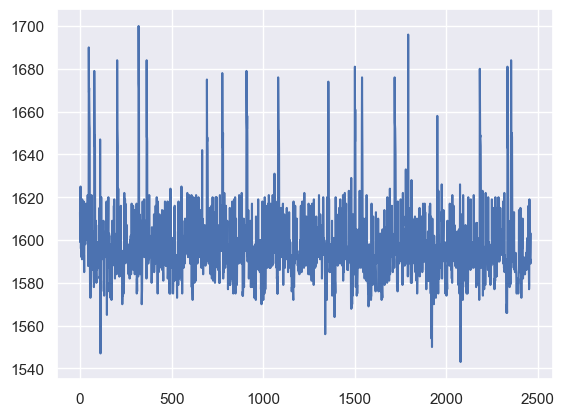

In [528]:
y.plot()

In [ ]:
y.describe()

In [529]:
X[22].describe()

C:\Users\user\pythonProjects\ml-tariff-classification\venv\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


count    2463.000000
mean             inf
std        24.953125
min      1519.000000
25%      1572.000000
50%      1588.000000
75%      1605.000000
max      1679.000000
Name: 22, dtype: float64

In [530]:
X[22].std()

24.95

<Axes: >

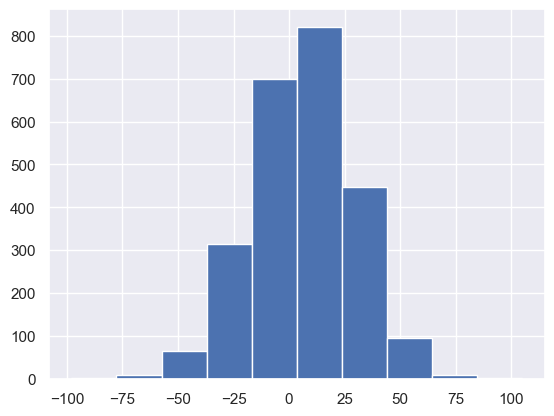

In [531]:
(y-X[22]).hist()

In [532]:
(pd.Series(grid_search.predict(X_test)) - X_test[22]).hist()

ValueError: operands could not be broadcast together with shapes (247,) (26,) 

In [533]:
model = LogisticRegression()

grid_search = GridSearchCV(estimator = model, param_grid={"max_iter": [1000]},
                           cv = 6,
                           verbose = 4)
grid_search.fit(X_train, y_train)

Fitting 6 folds for each of 1 candidates, totalling 6 fits


C:\Users\user\pythonProjects\ml-tariff-classification\venv\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


[CV 1/6] END .....................max_iter=1000;, score=0.043 total time=   0.7s
[CV 2/6] END .....................max_iter=1000;, score=0.065 total time=   0.5s
[CV 3/6] END .....................max_iter=1000;, score=0.054 total time=   0.5s
[CV 4/6] END .....................max_iter=1000;, score=0.068 total time=   0.5s
[CV 5/6] END .....................max_iter=1000;, score=0.051 total time=   0.6s
[CV 6/6] END .....................max_iter=1000;, score=0.051 total time=   0.7s


GridSearchCV(cv=6, estimator=LogisticRegression(),
             param_grid={'max_iter': [1000]}, verbose=4)

In [518]:
mean_absolute_error(y_test, grid_search.predict(X_test))

9.65